# <img src="https://raw.githubusercontent.com/alsinmr/SLEEPY_tutorial/033b817f027ebdcd6493a1f42ab9fdec290dbee8/JupyterBook/favicon.png"  width=40> <font  color = "#0093AF">Hamiltonians and Liouvillians</font>

Interactions and relaxation in the spin-system is determined by the Liouvillian, which consists of one or more Hamiltonians, relaxation terms, and exchange terms. SLEEPY operates in Liouville space, but the Hamiltonians are also calculated and can be accessed by the user. In this section, we discussion how the Hamiltonians and Liouvillians are build and how matrices in each may be accessed.

In [0]:
# SETUP SLEEPY
!pip install sleepy-nmr

## Setup

In [2]:
import SLEEPY as sl
import numpy as np

## The Hamiltonian

In the previous section, we defined the experimental conditions and the spin-system. The `ex` object, created with `sl.ExpSys`, contains all the information required to build the Hamiltonian and Liouvillian (for exchange, we need multiple `ex` objects).

SLEEPY operates in Liouville space, so while the Hamiltonian is in the background, the user will normally create the Liouvillian directly. Still, here we will start with the Hamiltonian and its contents.

We start with building `ex`, and then generate the Hamiltonian from `ex.Hamiltonian()`.

In [3]:
ex=sl.ExpSys(v0H=600,Nucs=['1H','13C'],vr=60000,LF=True)  #For this example, we'll work in the lab frame
ex.set_inter('dipole',i0=0,i1=1,delta=44000).set_inter('CSA',i=1,delta=100,eta=1).\
    set_inter('CS',i=0,ppm=10) #Add a dipole, CSA to 13C, and CS to 1H

H=ex.Hamiltonian() #Create the Hamiltonian

### Access and plot the Hamiltonian

To access Hamiltonian matrices, we have to specify which element of the powder average we are interested in, and also what step (up to `ex.n_gamma`) in the rotor cycle we want. For solution-state simulations, these are still required, but can both be set to zero. For example, for the first element of the powder average, and the first step in the rotor cycle, we use

In [4]:
H[0].H(0)

array([[ 3.75456344e+08+0.00000000e+00j,  1.21689737e+04-2.63141747e+03j,
         7.91082291e+03-1.66268635e+02j,  1.05759754e+04-4.44765395e+02j],
       [ 1.21689737e+04+2.63141747e+03j,  2.24549656e+08+0.00000000e+00j,
        -4.14676554e+02+3.33066907e-14j, -7.91082291e+03+1.66268635e+02j],
       [ 7.91082291e+03+1.66268635e+02j, -4.14676554e+02+3.33066907e-14j,
        -2.24550485e+08+0.00000000e+00j, -3.65267208e+03-2.29888020e+03j],
       [ 1.05759754e+04+4.44765395e+02j, -7.91082291e+03-1.66268635e+02j,
        -3.65267208e+03+2.29888020e+03j, -3.75455515e+08+0.00000000e+00j]])

Note that we have run the set up in the lab frame, explaining why the Hamiltonian is so dense. In the rotating frame, this will not be the case.

We may also visualize the Hamiltonian, using `H.plot()`. Plotting may be performed for a given element of the powder average, or if not specified, then an element halfway through the powder average is used.

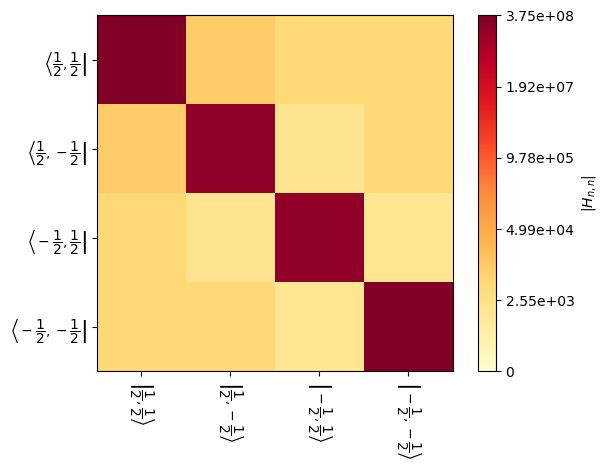

In [5]:
_=H[5].plot() #Plot the Hamiltonian for the 5th element of the powder average

The full Hamiltonian is built from the 5 rotating components of the Hamiltonian. If we have $n_\gamma$ steps per rotor period, and we're at the kth step, this is done as follows:

$$
\begin{eqnarray}
\phi_k&=&\exp(2\pi i k/n_\gamma) \nonumber \\
\hat{H}_k&=&\sum\limits_{n=-2}^2{\phi_k^{-n}*\hat{H}_n}
\end{eqnarray}
$$

The rotating components are obtained via the `H.Hn(n=...)` function, where n (-2,-1,0,1,2) must be provided. For example, for the fifth element of the powder average, if we want the $n=-1$ component, we would call:

In [6]:
H[5].Hn(-1)

array([[ 2440.46534251-283.23595211j,  2357.3085025 -273.58492108j,
         1339.43970543-343.9096637j ,  1015.12755055-260.64045519j],
       [ -631.63890955 +73.30685866j, -2440.46534251+283.23595211j,
        -1386.69002213+356.04148304j, -1339.43970543+343.9096637j ],
       [ -358.90178738 +92.15031666j, -1386.69002213+356.04148304j,
         -332.91470175+428.84701397j,  -321.57090837+414.23440632j],
       [-3788.50759481+972.72342127j,   358.90178738 -92.15031666j,
           86.16466521-110.99377465j,   332.91470175-428.84701397j]])

This may also be plotted. Note there are different plotting modes: 're','im','abs', 'log', and 'spy', which are real, imaginary, absolute value, log of absolute value, and spy, which is binary, i.e. zero or not zero.

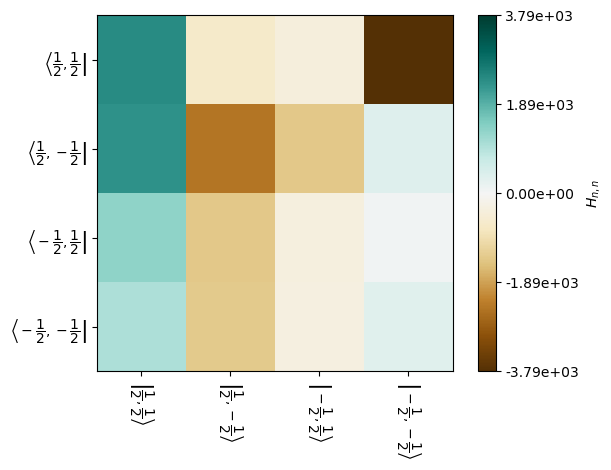

In [7]:
_=H[5].plot('H1',mode='re')

### Hamiltonians for individual interactions

The rotating components are built up from the rotating components of the individual interactions, where individual interactions are found in the list stored in `H.Hinter`. Indexing this list will return a description of the interaction, for example:

In [8]:
H.Hinter[0]

Hamiltonian for a single interaction
Type: dipole between spins 0 and 1
Arguments:
	delta=44000
	eta=0
	euler=[0.00,0.00,0.00]


The Hamiltonians are those specified when using `ex.set_inter(...)`. However, if a spin is specified in the lab frame, then we will also find a Hamiltonian for the Zeeman interaction for those spins. As with the full Hamiltonian, we may plot Hamiltonians for the individual interactions.

In [9]:
H.Hinter[-1]

Hamiltonian for a single interaction
Type: larmor on spin 1


Below, we plot the real part of the dipole Hamiltonian. Note that the values shown depend on the element of the powder average, determined below by setting `H[5]` and the step in the rotor period (`step=25`).

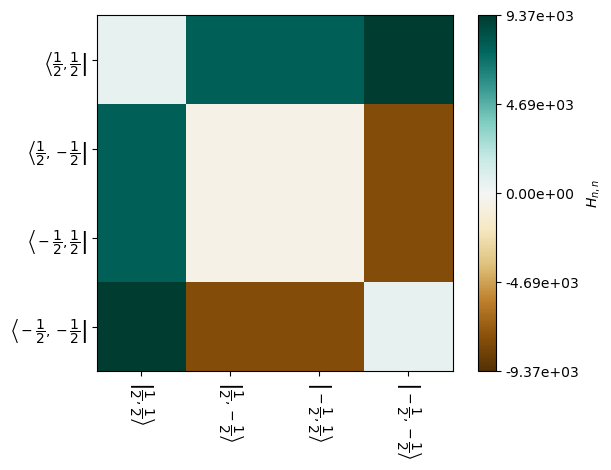

In [10]:
_=H[5].Hinter[0].plot(mode='re',step=25)

## The Liouvillian

Coherent components of the Liouvillian are calculated from the Hamiltonian, although we may also add relaxation and exchange processes to the Liouvillian. We create the Liouvillian without exchange either from the Hamiltonian or the experimental system (`ex.Liouvillian()`). 

In [11]:
L=ex.Liouvillian()  
L=H.Liouvillian() #alternatively
L=sl.Liouvillian(ex) #alternatively

The coherent Liouvillian is created by calculating

$$
\begin{equation}
\hat{\hat{L}}=i(\hat{H}\otimes\hat{\mathbf{1}}-\hat{\mathbf{1}}\otimes\hat{H})
\end{equation}
$$

$\hat{\mathbf{1}}$ is an identity matrix with the same dimensions as $\hat{H}$. In SLEEPY, we separate the individual components, such that we acquired

$$
\begin{equation}
\hat{\hat{L}}_n=i(\hat{H}_n\otimes\hat{\mathbf{1}}-\hat{\mathbf{1}}\otimes\hat{H}_n^T)
\end{equation}
$$

$^\mathrm{T}$ indicates the transpose without complex conjugate on the Hamiltonian

### Access and plot the Liouvillian

Access to specific components of the Liouvillian and plotting use the same rules as for the Hamiltonian. For example, to access the 5th element of the powder average, and the $n=1$ component of the coherent Liouvillian, we would use
```
L[5].Ln(1)
```
Note that the $n=0$ component contains contributions from relaxation (non-orientation specific) and exchange. To obtain the pure coherent contributions, we use
```
L[5].Ln_H(1)
```
The full Liouvillian for a given element of the powder average and step in the rotor period is obtained via:
```
L[5].L(10)  #5th powder average element, 10th step
```
We may also plot these matrices, which is particularly helpful since the Liouvillian gets relatively large and numerical display of the full matrix may not be very helpful.

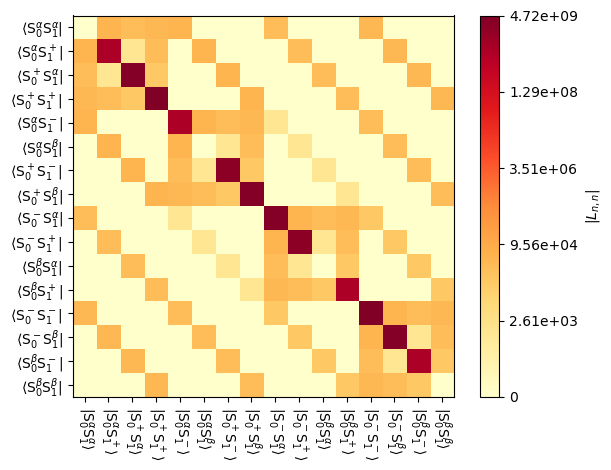

In [12]:
_=L[0].plot()  #Full Liouvillian

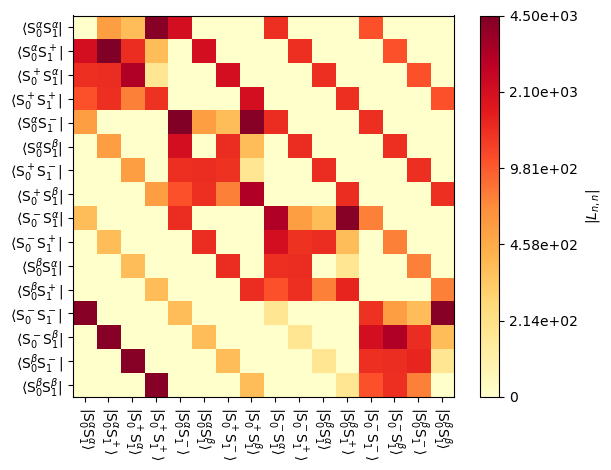

In [13]:
_=L[0].plot('L-1') #n=-1 component of the coherent Liouvillian

### Adding relaxation

$T_1$ and $T_2$ relaxation is available in SLEEPY, along with "Spin-Diffusion" which just introduces signal decay with $T_1=T_2$ (see Ernst et al. for spin-diffusion relaxation operator$^1$). As implemented in SLEEPY, the $T_1$ option *only* decays along $z$, which is unphysical, so it is important to also add some $T_2$ relaxation when using $T_1$. By default, $T_1$ acts along $z$, and $T_2$ along x and y. However, it is possible to specify "orientation-specific" (`OS=True`) relaxation, which will adjust $T_1$ relaxation to occur among the eigenstates of a given spin, and $T_2$ acts on coherences between eigenstates of the spin. This option is more computationally expensive. However, for spins that are strongly tilted away from $z$, using the default relaxation will "mix" the $T_1$ and $T_2$ behavior, so that $T_1$ may appear much shorter than specified (see [Relaxation Options](../Chapter6/Ch6_RelaxationOptions.ipynb)). 

We may also include recovery of magnetization to thermal equilibrium (noting that in this case, `ex.T_K` determines the equilibrium density matrix). If orientation-specific relaxation is included, this is specified when the relaxation is added. Otherwise, it is specified after all relaxation is included. Relaxation is removed by running `L.clear_relax()`. If, for example, $T_1$ relaxation is added to a spin twice without clearing the first entry, then the relaxation rates will add together, so it is important not to forget to clear existing relaxation.

[1] M. Ernst, H. Zimmermann, B.H. Meier. [*Chem. Phys. Lett.*](https://doi.org/10.1016/S0009-2614(99)01423-2), **2000**, 317, 581-588.

In [14]:
L.clear_relax()
L.add_relax('T1',i=0,T1=1)  #Add T1 relaxation to spin 0
L.add_relax('T2',i=0,T2=.1) #Add T2 relaxation to spin 0
L.add_relax('T1',i=1,T1=5)  #Add T1 relaxation to spin 0
L.add_relax('T2',i=1,T2=.5) #Add T2 relaxation to spin 0
_=L.add_relax('recovery') #Add recovery to thermal equilibrium

To add orientation-specific relaxation, specify `OS=True`. To include recovery to thermal equilibrium, $T_1$ requires specifying `Thermal=True`.

In [15]:
L.clear_relax()
L.add_relax('T1',i=0,T1=1,OS=True,Thermal=True)  #Add T1 relaxation to spin 0
L.add_relax('T2',i=0,T2=.1,OS=True) #Add T2 relaxation to spin 0
L.add_relax('T1',i=1,T1=5,OS=True,Thermal=True)  #Add T1 relaxation to spin 0
_=L.add_relax('T2',i=1,T2=.5,OS=True) #Add T2 relaxation to spin 0

We can visualize the result with the plot function.

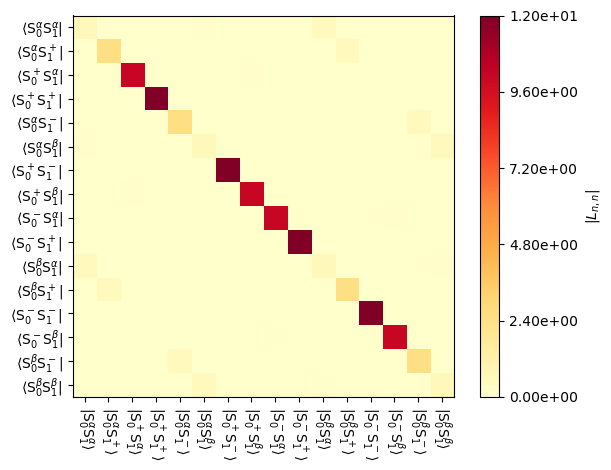

In [16]:
_=L.plot('Lrelax',mode='abs')

### Exchange

Importantly, SLEEPY allows us to simulate magnetic resonance under exchange conditions. This is achieved by defining two or more experimental system objects, with different interactions. In this example, we just change the orientation of the dipole coupling, representing a hopping motion.

Since the resulting Liouvillian comes from multiple experimental systems (`ex0,ex1`), we must use `sl.Liouvillian`, rather than generating it directly from `ex`.

In [17]:
ex1=ex.copy() #We can copy an existing ex, so that to start, all parameters match
ex1.set_inter('dipole',i0=0,i1=1,delta=44000,euler=[0,30*np.pi/180,0]) #30 degree hop

L=sl.Liouvillian(ex,ex1)

We can plot the resulting Liouvillian, to see that it now has larger dimensions, corresponding to the two experimental systems that were input.

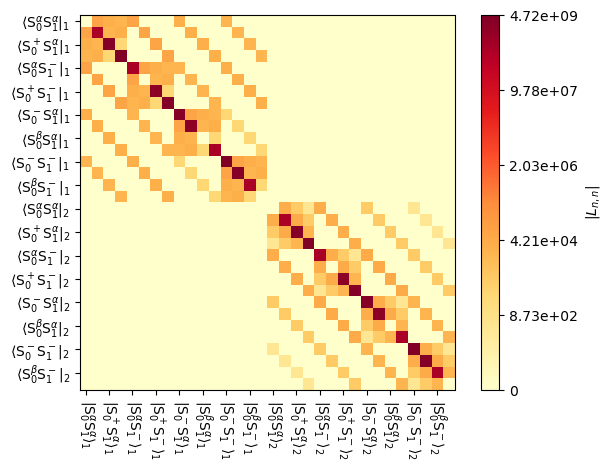

In [18]:
_=L.plot()

On its own, this isn't very useful because the two dipole orientations are not exchanging. For this, we must also include the exchange matrix, of the form:

$$
\begin{equation}
\mathbf{K}_{ex}=
\begin{pmatrix}
-k_{01}&k_{10} \\
k_{01}&-k_{10}
\end{pmatrix}
\end{equation}
$$

Exchange matrices should always be mass conserving, i.e., the columns should sum to 0. Usually, they should also satisfy detailed balance, i.e., $k_{m,n}/k_{n,m}=p_n/p_m$ where $p_n$ are equilibrium populations.

In [19]:
L.kex=[[-1e3,1e3],[1e3,-1e3]]  #Symmetric exchange between two sites

A number of tools exist in sl.Tools for building various exchange matrices. Some functions also set up both the exchange matrix and multiple experimental systems (`twoSite_kex`,`nSite_sym`,`fourSite_sym`,`Setup3siteSym`,`SetupTetraHop`).

Below, we show the exchange component of the Liouvillian

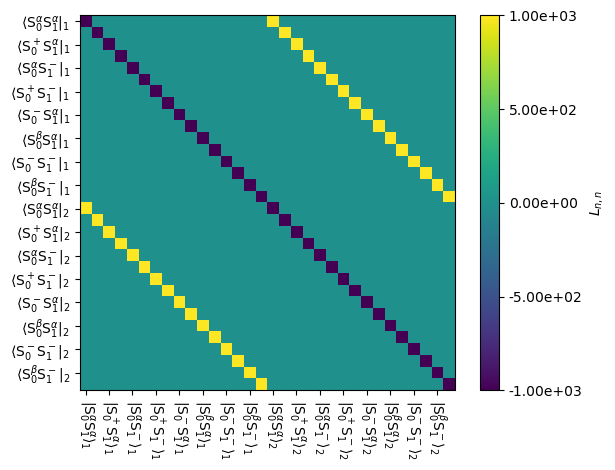

In [20]:
_=L.plot('Lex',mode='re')

Finally, we show the total Liouvillian, including exchange.

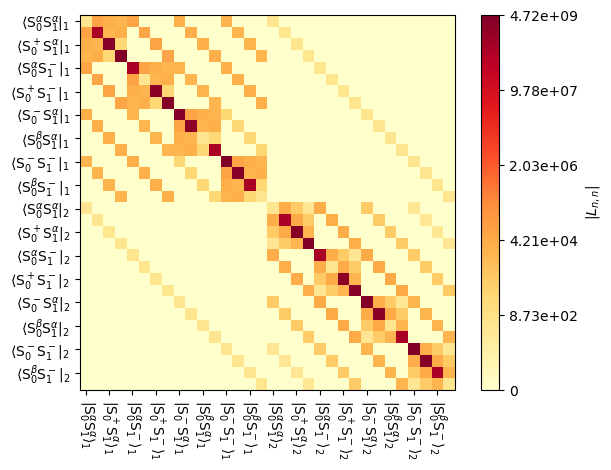

In [21]:
_=L.plot()

In the next section, we discuss the generation of propagators and sequences from the Liouvillian.